# Assignment 3_2: Echo State Networks

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float64)

from esn import *
from learning import *

In [2]:
narma_df = pd.read_csv('../NARMA10.csv', header=None)
narma_df.iloc[:, :20] # visualize the first 20 columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,0.048365,0.40907,0.40877,0.36122,0.074933,0.32980,0.25930,0.48649,0.32450,0.40017
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.132850,0.17536,0.37127,0.36481,0.337070,0.20447,0.33003,0.20726,0.18825,0.28343


In [3]:
x_data = torch.tensor(narma_df.iloc[0].values, dtype=torch.float64) # float 32 for better memory efficiency
y_data = torch.tensor(narma_df.iloc[1].values, dtype=torch.float64)

# 4000 tr, 1000 val, 5000 test (WARNING: load entire dataset in memory ONLY because it is small and also the NN is quite small)
dev_x, dev_y = x_data[:5000], y_data[:5000] # only used for retraining (train + val sets)

test_x, test_y = x_data[5000:], y_data[5000:]

train_x, val_x = dev_x[:4000], dev_x[4000:]
train_y, val_y = dev_y[:4000], dev_y[4000:]

In [4]:
dev_x = dev_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
train_x = train_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
val_x = val_x.unsqueeze(1).unsqueeze(1) # shape needed by the model
test_x = test_x.unsqueeze(1).unsqueeze(1)

train_x.shape, val_x.shape, dev_x.shape, test_x.shape # check shapes (L, N, D)

(torch.Size([4000, 1, 1]),
 torch.Size([1000, 1, 1]),
 torch.Size([5000, 1, 1]),
 torch.Size([5000, 1, 1]))

In [5]:
'''hyperparams = {
    'hidden_size': [512, 1024], 
    'ridge_regression':  [1e-6, 1e-8],
    'omhega_in': [0.4, 0.8],
    'omhega_b': [0.1, 0.3], 
    'rho': [0.8, 0.9, 0.99],
    'washout': [100, 1000],
}

model_selection_history = grid_search(hyperparams, train_x, train_y, val_x, val_y, n_iter=5) 

df = pd.DataFrame.from_dict(model_selection_history, orient='index')
df.to_csv('esn_grid_search.csv')'''

"hyperparams = {\n    'hidden_size': [512, 1024], \n    'ridge_regression':  [1e-6, 1e-8],\n    'omhega_in': [0.4, 0.8],\n    'omhega_b': [0.1, 0.3], \n    'rho': [0.8, 0.9, 0.99],\n    'washout': [100, 1000],\n}\n\nmodel_selection_history = grid_search(hyperparams, train_x, train_y, val_x, val_y, n_iter=5) \n\ndf = pd.DataFrame.from_dict(model_selection_history, orient='index')\ndf.to_csv('esn_grid_search.csv')"

In [6]:
'''df_results = pd.read_csv('esn_grid_search.csv', index_col=0)
df_results.sort_values(by='val_mse_mean', ascending=True).head(10)'''

"df_results = pd.read_csv('esn_grid_search.csv', index_col=0)\ndf_results.sort_values(by='val_mse_mean', ascending=True).head(10)"

In [13]:
esn = RegressorESN(1, 1024, 1e-6, 0.7, 0.8, 0.9)
h = esn.fit(train_x, train_y, 100)
esn.train()
pred = esn(train_x, None)

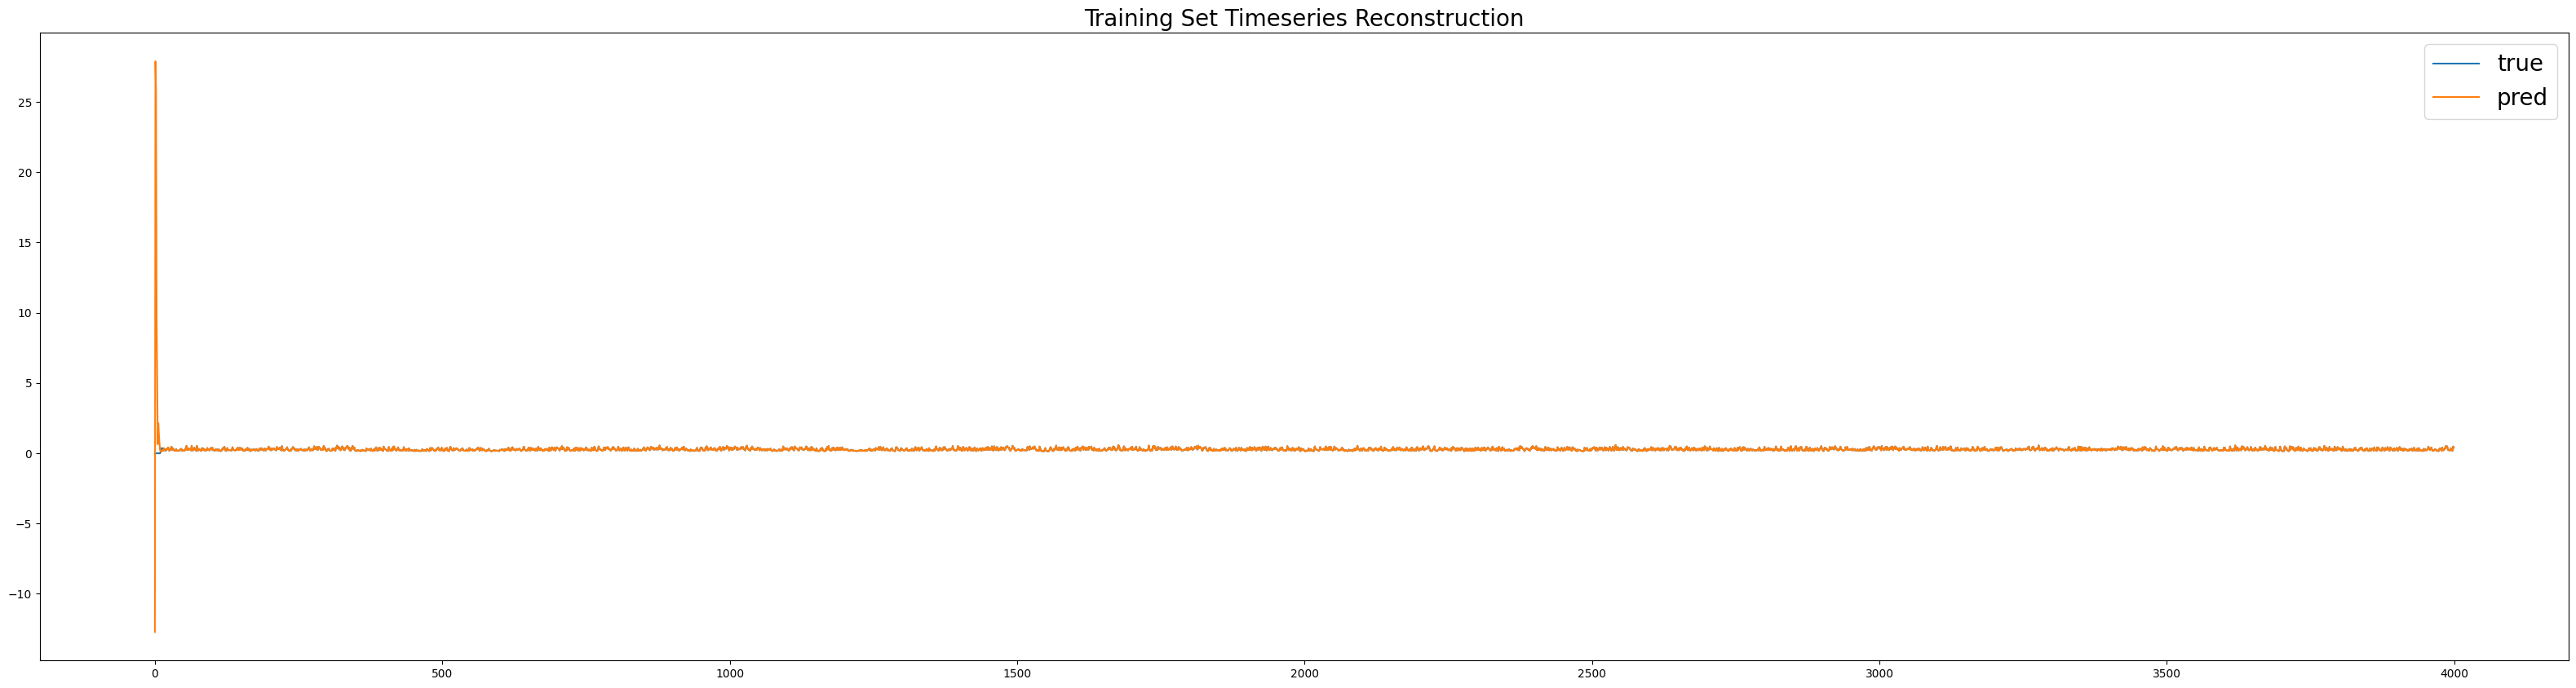

In [14]:
plt.figure(figsize=(40, 10))
plt.title(f'Training Set Timeseries Reconstruction', fontsize=20)
plt.plot(train_y, label='true')
plt.plot(pred, label='pred')
plt.legend(fontsize=20)

In [9]:
pred = esn(test_x, h)

l = torch.nn.MSELoss()
test_loss = l(pred, test_y)

plt.figure(figsize=(40, 10))
plt.title(f'Test Set Timeseries Reconstruction - Test MSE: {test_loss.item()}', fontsize=20)
plt.plot(test_y, label='true')
plt.plot(pred, label='pred')
plt.legend(fontsize=20)

/home/jacopo/cns/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5000])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (4000) must match the size of tensor b (5000) at non-singleton dimension 0